# Policy-based Agents

Re-write of code from [Simple Reinforcement Learning with Tensorflow: Part 2 - Policy-based Agents](https://medium.com/@awjuliani/super-simple-reinforcement-learning-tutorial-part-2-ded33892c724#.zh7rnjs25)

In [14]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from IPython import display
import gym

In [15]:
env = gym.make("CartPole-v0")

# Simulate environment

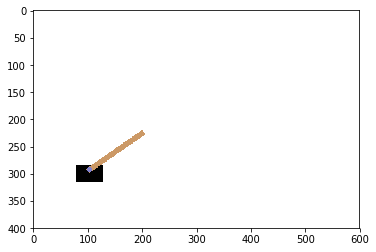

In [16]:

env.reset()
img = plt.imshow(env.render(mode='rgb_array')) # only call this once
for _ in range(100):
    img.set_data(env.render(mode='rgb_array')) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)
    action = env.action_space.sample()
    env.step(action)

In [3]:
# Try running environment with random actions
env.reset()
reward_sum = 0
num_games = 10
num_game = 0
while num_game < num_games:
#     env.render()
    observation, reward, done, _ = env.step(env.action_space.sample())
    reward_sum += reward
    if done:
        print("Reward for this episode was: {}".format(reward_sum))
        reward_sum = 0
        num_game += 1
        env.reset()

Reward for this episode was: 13.0
Reward for this episode was: 35.0
Reward for this episode was: 13.0
Reward for this episode was: 11.0
Reward for this episode was: 15.0
Reward for this episode was: 12.0
Reward for this episode was: 129.0
Reward for this episode was: 17.0
Reward for this episode was: 13.0
Reward for this episode was: 16.0


## Setting up a Neural Network agent
We will use a policy neural network that takes observations, passes them through a single hidden layer and then produces a probability of choosing a left/right movement.

In [7]:
import keras.layers as layers
from keras.models import Model
from keras.optimizers import Adam
import keras.backend as K
from keras.initializers import glorot_uniform

def get_policy_model(env, hidden_layer_neurons, lr):
    dimen = env.reset().shape
    num_actions = env.action_space.n
    inp = layers.Input(shape=dimen,name="input_x")
    adv = layers.Input(shape=[1], name="advantages")
    x = layers.Dense(hidden_layer_neurons, 
                     activation="relu", 
                     use_bias=False,
                     kernel_initializer=glorot_uniform(seed=42),
                     name="dense_1")(inp)
    out = layers.Dense(num_actions, 
                       activation="softmax", 
                       kernel_initializer=glorot_uniform(seed=42),
                       use_bias=False,
                       name="out")(x)

    def custom_loss(y_true, y_pred):
        # actual: 0 predict: 0 -> log(0 * (0 - 0) + (1 - 0) * (0 + 0)) = -inf
        # actual: 1 predict: 1 -> log(1 * (1 - 1) + (1 - 1) * (1 + 1)) = -inf
        # actual: 1 predict: 0 -> log(1 * (1 - 0) + (1 - 1) * (1 + 0)) = 0
        # actual: 0 predict: 1 -> log(0 * (0 - 1) + (1 - 0) * (0 + 1)) = 0
        log_lik = K.log(y_true * (y_true - y_pred) + (1 - y_true) * (y_true + y_pred))
        return K.mean(log_lik * adv, keepdims=True)
        
    model_train = Model(inputs=[inp, adv], outputs=out)
    model_train.compile(loss=custom_loss, optimizer=Adam(lr))
    model_predict = Model(inputs=[inp], outputs=out)
    return model_train, model_predict

C:\Dev\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [9]:
def discount_rewards(r, gamma=0.99):
    """Takes 1d float array of rewards and computes discounted reward
    e.g. f([1, 1, 1], 0.99) -> [2.9701, 1.99, 1]
    """
    prior = 0
    out = []
    for val in r:
        new_val = val + prior * gamma
        out.append(new_val)
        prior = new_val
    return np.array(out[::-1])

In [10]:
# Constants defining our neural network
hidden_layer_neurons = 8
gamma = .99
dimen = len(env.reset())
print_every = 100
batch_size = 50
num_episodes = 10000
render = False
lr = 1e-2
goal = 190

In [12]:
# See our trained bot in action
def score_model(model, num_tests, render=False):
    scores = []    
    for num_test in range(num_tests):
        observation = env.reset()
        reward_sum = 0
        while True:
            if render:
                env.render()

            state = np.reshape(observation, [1, dimen])
            predict = model.predict([state])[0]
            action = np.argmax(predict)
            observation, reward, done, _ = env.step(action)
            reward_sum += reward
            if done:
                break
        scores.append(reward_sum)
    env.close()
    return np.mean(scores)

In [13]:
model_train, model_predict = get_policy_model(env, hidden_layer_neurons, lr)
model_predict.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_x (InputLayer)         (None, 4)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 32        
_________________________________________________________________
out (Dense)                  (None, 2)                 16        
Total params: 48
Trainable params: 48
Non-trainable params: 0
_________________________________________________________________


In [ ]:
reward_sum = 0

num_actions = env.action_space.n

# Placeholders for our observations, outputs and rewards
states = np.empty(0).reshape(0,dimen)
actions = np.empty(0).reshape(0,1)
rewards = np.empty(0).reshape(0,1)
discounted_rewards = np.empty(0).reshape(0,1)

# Setting up our environment
observation = env.reset()

num_episode = 0

losses = []

while num_episode < num_episodes:
    # Append the observations to our batch
    state = np.reshape(observation, [1, dimen])
    
    predict = model_predict.predict([state])[0]
    action = np.random.choice(range(num_actions),p=predict)
    
    # Append the observations and outputs for learning
    states = np.vstack([states, state])
    actions = np.vstack([actions, action])
    
    # Determine the oucome of our action
    observation, reward, done, _ = env.step(action)
    reward_sum += reward
    rewards = np.vstack([rewards, reward])
    
    if done:
        # Determine standardized rewards
        discounted_rewards_episode = discount_rewards(rewards, gamma)       
        discounted_rewards = np.vstack([discounted_rewards, discounted_rewards_episode])
        
        rewards = np.empty(0).reshape(0,1)

        if (num_episode + 1) % batch_size == 0:
            discounted_rewards -= discounted_rewards.mean()
            discounted_rewards /= discounted_rewards.std()
            discounted_rewards = discounted_rewards.squeeze()
            actions = actions.squeeze().astype(int)
           
            actions_train = np.zeros([len(actions), num_actions])
            actions_train[np.arange(len(actions)), actions] = 1
            
            loss = model_train.train_on_batch([states, discounted_rewards], actions_train)
            losses.append(loss)

            # Clear out game variables
            states = np.empty(0).reshape(0,dimen)
            actions = np.empty(0).reshape(0,1)
            discounted_rewards = np.empty(0).reshape(0,1)


        # Print periodically
        if (num_episode + 1) % print_every == 0:
            # Print status
            score = score_model(model_predict,10)
            print("Average reward for training episode {}: {:0.2f} Test Score: {:0.2f} Loss: {:0.6f} ".format(
                (num_episode + 1), reward_sum/print_every, 
                score,
                np.mean(losses[-print_every:])))
            
            if score >= goal:
                print("Solved in {} episodes!".format(num_episode))
                break
            reward_sum = 0
                
        num_episode += 1
        observation = env.reset()
        

In [ ]:
env.close()